# Calibrating Jensen Shannon

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so


from distribution_diff import jensen_shannon_divergence, DistCalculator

## Generate the reference distribution

Gaussian, mean 0, standard deviation 1

In [2]:
rng = np.random.default_rng(seed=20230905)
reference_dist = rng.normal(loc=0, scale=1, size=1000)


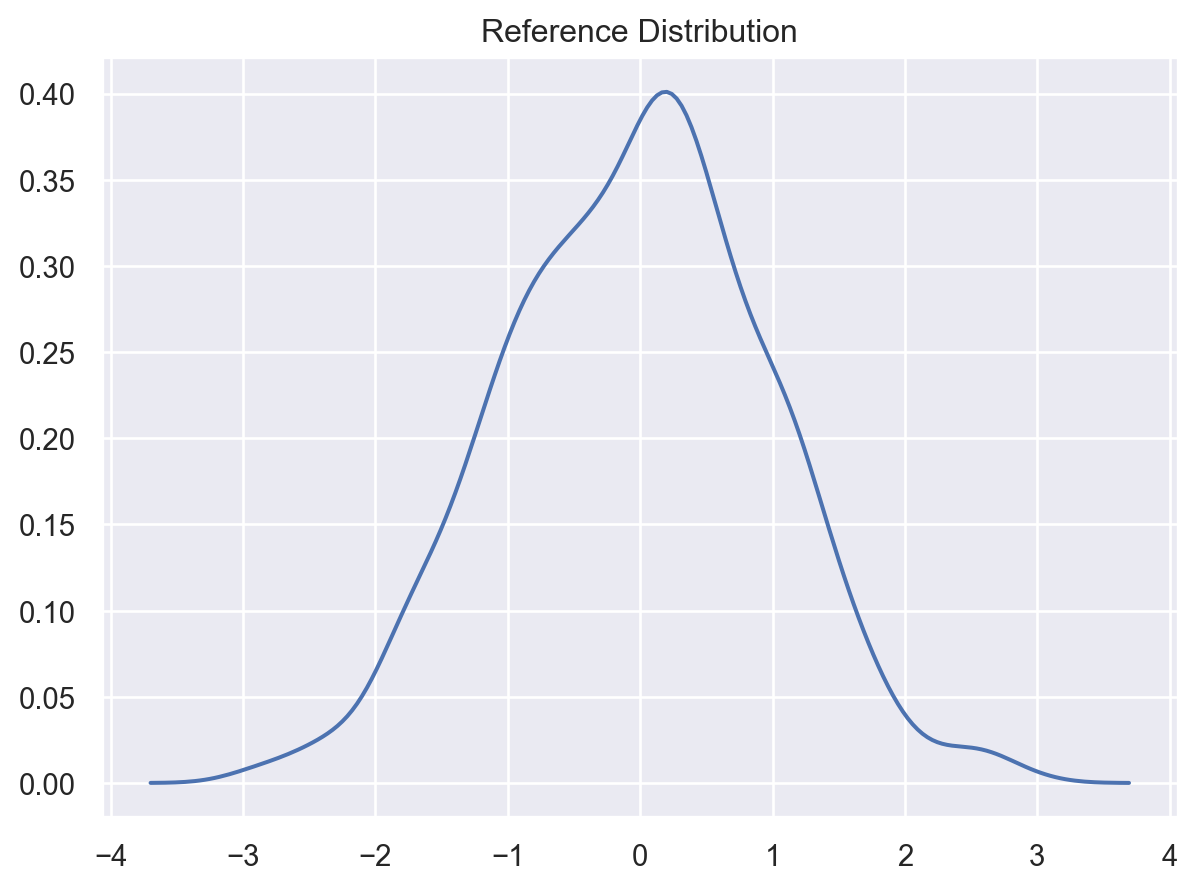

In [3]:
p = so.Plot(x=reference_dist).add(so.Line(), so.KDE())
p.label(title="Reference Distribution")

In [4]:
# create a PSI calculator with this reference distribution
psiCalc = DistCalculator(reference_dist)

## Bootstrap sampling

Both Jensen-Shannon and PSI will be measured with decile binning.

In [5]:
niters = 1000
jsvec = []
psivec = []

for i in range(niters):
    bsample = rng.choice(reference_dist, size=len(reference_dist), replace=True)
    jsvec.append(jensen_shannon_divergence(bsample, reference_dist))
    psivec.append(psiCalc.PSI(bsample))

flist = [
    pd.DataFrame({
        'div': jsvec,
        'type': 'Jensen-Shannon'
    }),
    pd.DataFrame({
        'div': psivec,
        'type': 'PSI'
    }),
]

pframe = pd.concat(flist)
pframe


,div,type
0,0.001579,Jensen-Shannon
1,0.001959,Jensen-Shannon
2,0.001040,Jensen-Shannon
3,0.005361,Jensen-Shannon
4,0.001679,Jensen-Shannon
...,...,...
995,0.006392,PSI
996,0.009463,PSI
997,0.004047,PSI
998,0.002705,PSI


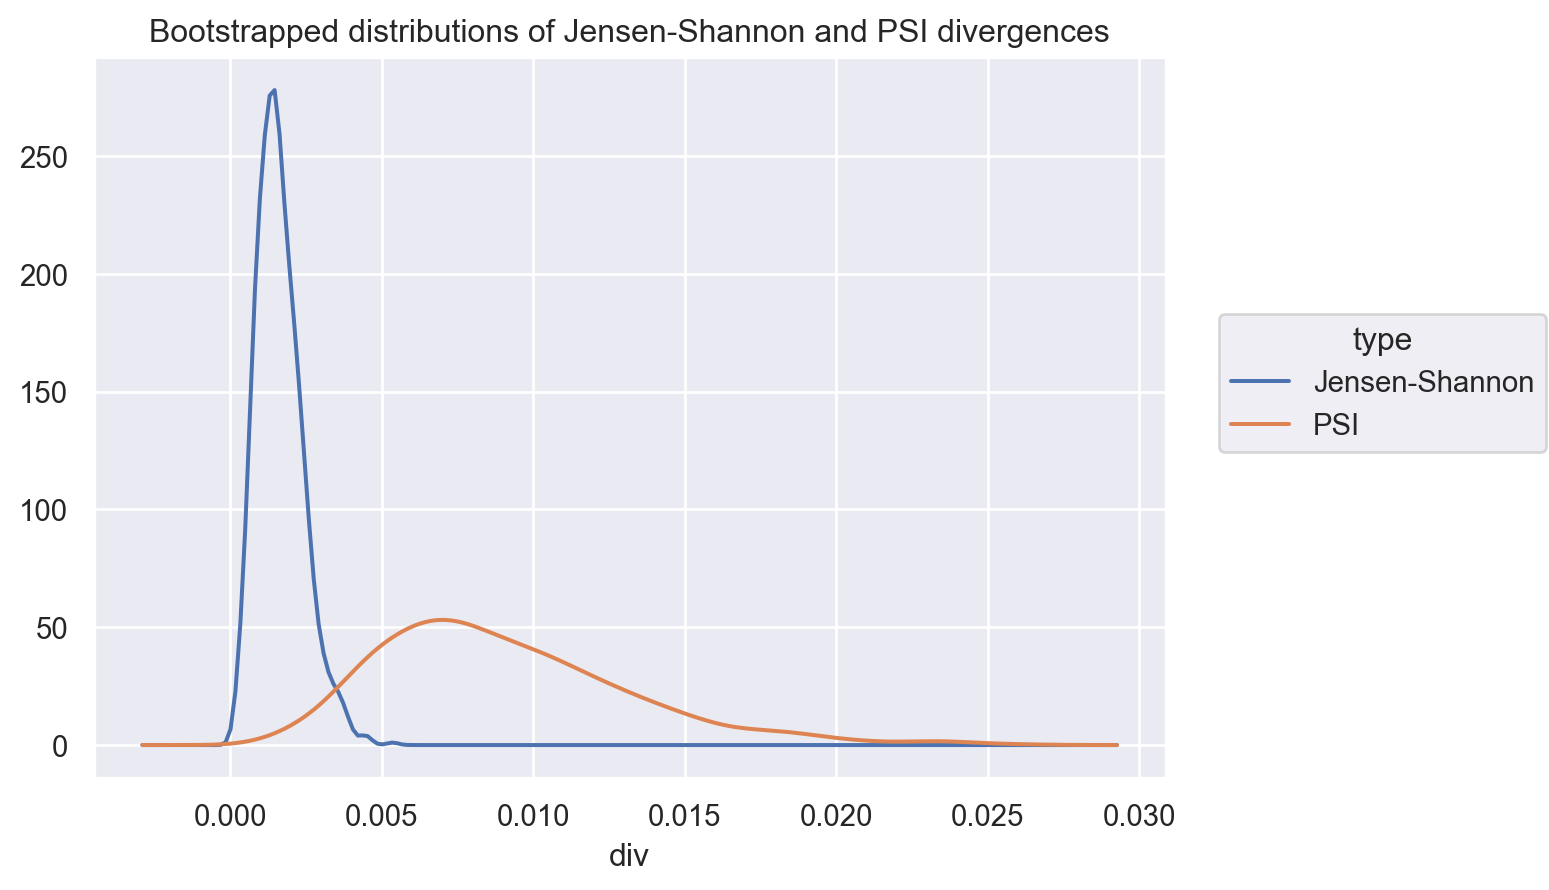

In [6]:
p = so.Plot(pframe, "div", color="type").add(so.Line(), so.KDE())
p.label(title='Bootstrapped distributions of Jensen-Shannon and PSI divergences')

## Distribution drift

We'll be measuring increasing variance (but we'll hold the mean the same)

In [7]:
def generate_comparison(newscale, niter=10):
    jsvec = []
    psivec = []
    for i in range(niter):
        bsample = rng.normal(loc=0, scale=newscale, size=1000)
        jsvec.append(jensen_shannon_divergence(bsample, reference_dist))
        psivec.append(psiCalc.PSI(bsample))

    ns = f'{newscale:.2f}'

    cframe = pd.DataFrame({
        'scale': newscale,
        'PSI': psivec,
        'Jensen-Shannon': jsvec
    })

    return(cframe)
    

def minmax(v):
    return np.array([v.min(), v.max()])

In [8]:
newscales = np.linspace(1, 2, num=20, endpoint=True)
flist = [generate_comparison(ns) for ns in newscales]
pframe = pd.concat(flist, ignore_index=True)
pframe


,scale,PSI,Jensen-Shannon
0,1.0,0.022527,0.004197
1,1.0,0.021158,0.005076
2,1.0,0.015787,0.002124
3,1.0,0.035277,0.005830
4,1.0,0.026950,0.004568
...,...,...,...
195,2.0,0.503845,0.122237
196,2.0,0.492617,0.127541
197,2.0,0.502127,0.111315
198,2.0,0.541353,0.116273


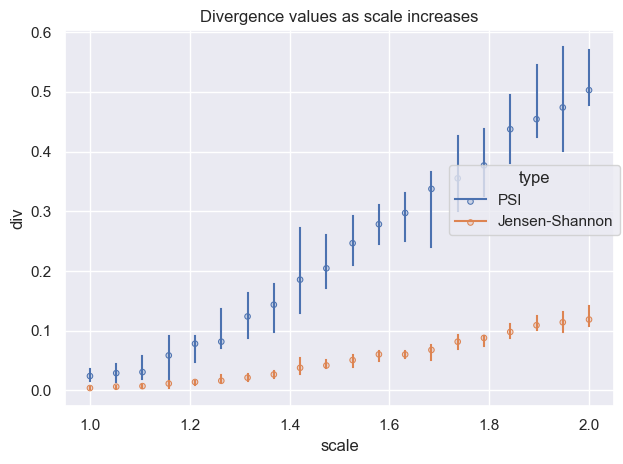

In [9]:
plong = pd.concat([
        pd.DataFrame({
              'scale': pframe['scale'],
              'div': pframe['PSI'],
              'type': 'PSI'
       }),
       pd.DataFrame({
              'scale': pframe['scale'],
              'div': pframe['Jensen-Shannon'],
              'type': 'Jensen-Shannon'
       })
])

plong
      

p = (so.Plot(plong, x="scale", y="div", color="type")
       .add(so.Dots(), so.Agg("median"))
       .add(so.Range(), so.Est(errorbar=minmax))
       .label(title='Divergence values as scale increases')
)

p.show()


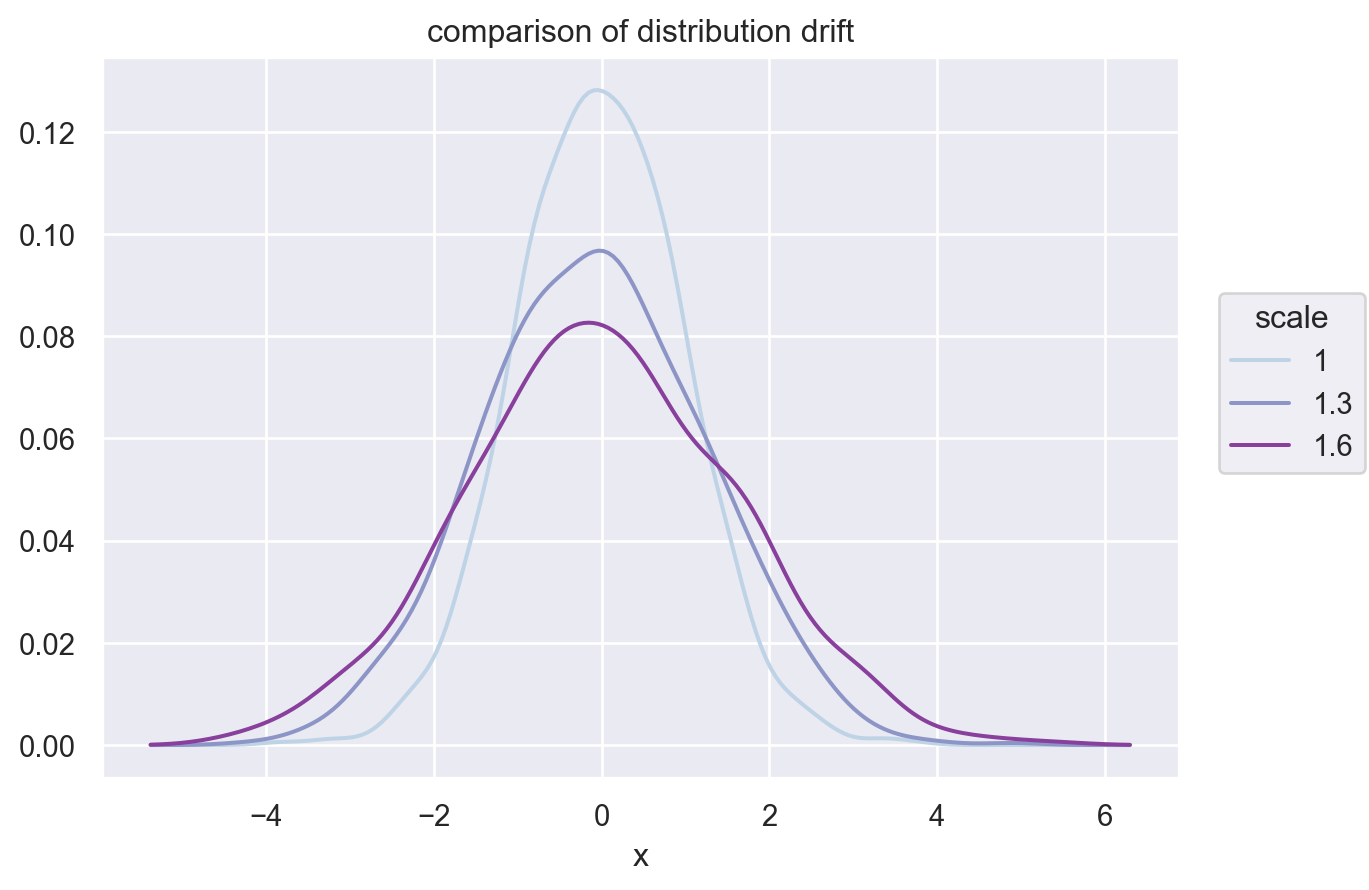

In [10]:
# let's see what those distributions look like
ref = pd.DataFrame({
    'scale': '1',
    'x': rng.normal(loc=0, scale=1, size=1000)
})

# somewhat different (according to PSI)
somewhat = pd.DataFrame({
    'scale': '1.3',
    'x': rng.normal(loc=0, scale=1.3, size=1000)
})

# very different (accordint to PSI)
different = pd.DataFrame({
    'scale': '1.6',
    'x': rng.normal(loc=0, scale=1.6, size=1000)
})

dframe = pd.concat([ref, somewhat, different], ignore_index=True)

p = so.Plot(dframe, "x", color="scale").add(so.Line(), so.KDE()).scale(color="BuPu")
p.label(title='comparison of distribution drift')

In [11]:
# plot JS as a function of PSI

pframe['PSI heuristic'] = np.where(pframe['PSI'] < 0.1, 'not very different',
                                   np.where(pframe['PSI'] > 0.25, 'very different', 'somewhat different'))
pframe

,scale,PSI,Jensen-Shannon,PSI heuristic
0,1.0,0.022527,0.004197,not very different
1,1.0,0.021158,0.005076,not very different
2,1.0,0.015787,0.002124,not very different
3,1.0,0.035277,0.005830,not very different
4,1.0,0.026950,0.004568,not very different
...,...,...,...,...
195,2.0,0.503845,0.122237,very different
196,2.0,0.492617,0.127541,very different
197,2.0,0.502127,0.111315,very different
198,2.0,0.541353,0.116273,very different


## Fit the relationship

And yes, I know I should probably do this with `statsmodels`, but sklearn is easier to use, and I'm not concerned with significances (given that the relationship is quite clear).

In [12]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(pframe.loc[:, ['PSI']], pframe['Jensen-Shannon'])

LinearRegression()

So one can say (at least for this problem, in this range) that the Jensen Shannon divergence approximately obeys the below relationship to PSI. 

The relationship likely will vary with the distribution (see `test_cnc_anomaly.ipynb` for another example.)

In [13]:
[lm.intercept_, lm.coef_]

[-0.004126285482173413, array([0.23407312])]

In [14]:

pf2pred = pd.DataFrame({
    'PSI': pframe['PSI'],
    'Jensen-Shannon': lm.predict(pframe.loc[:, ['PSI']])
})


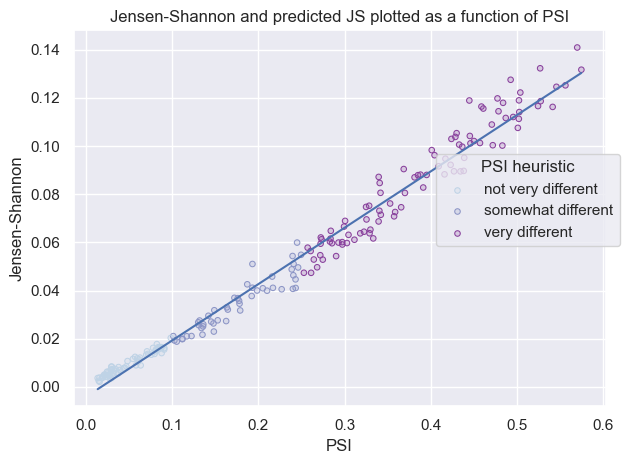

In [15]:
# ok, so this is more awkward than ggplot2.
p = (so.Plot(pframe, x="PSI", y="Jensen-Shannon").scale(color="BuPu")
       .add(so.Dots(), color="PSI heuristic")
       .add(so.Line(), data=pf2pred)
       .label(title='Jensen-Shannon and predicted JS plotted as a function of PSI')
)

p.show()


In [16]:
tmat = pd.DataFrame({'PSI': [0.1, 0.25]})
js_thresh = lm.predict(tmat)

print(f'''
Heuristic thresholds for Jensen-Shannon divergence:
* over {js_thresh[0]:.3f}: "somewhat different"
* over {js_thresh[1]:.3f}: "very different"
''')


Heuristic thresholds for Jensen-Shannon divergence:
* over 0.019: "somewhat different"
* over 0.054: "very different"

